# Visual Speech Recognition (Lip Reading)

## Objective:
To develop a deep learning model that can recognize spoken words from silent video clips by analyzing lip movements, enabling speech recognition without relying on audio input.

## Project:
This project implements a Visual Speech Recognition system using a 3D Convolutional Neural Network (3D CNN). The model is trained to classify video sequences of people speaking specific words by learning spatio-temporal features across frames. The pipeline includes downloading and preparing the dataset, normalizing and encoding the data, building the 3D CNN architecture, training the model, evaluating performance, and visualizing the results. This demonstrates the use of computer vision and deep learning techniques to recognize speech purely from visual input.

## Dataset Credit:
The dataset used in this project is the **Best Lip Reading Dataset**, available on [Kaggle](https://www.kaggle.com/datasets/allenye66/best-lip-reading-dataset), provided by Allen Ye.


### Upload Kaggle API key and download the Lip Reading dataset  
Upload `kaggle.json`, set permissions, and download + unzip the dataset from Kaggle using the Kaggle API.

In [ ]:
from google.colab import files
files.upload()

import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d allenye66/best-lip-reading-dataset
!unzip -q best-lip-reading-dataset.zip -d /content/lip_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/allenye66/best-lip-reading-dataset
License(s): unknown
 94% 690M/733M [00:06<00:00, 85.2MB/s]
100% 733M/733M [00:06<00:00, 112MB/s] 


### Importing necessary libraries  
This section includes all essential libraries for model building, data preprocessing, evaluation, and visualization.


In [ ]:
import numpy as np
import os
from keras.layers import Conv3D, MaxPooling3D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, LabelEncoder
import tensorflow as tf
import seaborn as sns
from keras import regularizers

### Loading and preprocessing video data  
This section walks through collecting `data.txt` files from all class folders, extracting video frame data, reshaping it, and saving processed arrays (`videosCorrect.npy`, `labelsCorrect.npy`) for later use.


In [ ]:
import os
import numpy as np
import ast
from tqdm import tqdm  # Progress bar

dir_path = "/content/lip_data/outputs"

height, width, channels = 80, 112, 3
videos = []
labels = []

file_list = []
for root, dirs, files in os.walk(dir_path):
    for file in files:
        if file == "data.txt":
            file_list.append(os.path.join(root, file))

print(f"Found {len(file_list)} data.txt files.")

# Read all data files with progress bar
for path in tqdm(file_list, desc="Processing video samples"):
    label = os.path.basename(os.path.dirname(path)).split("_")[0]
    with open(path, 'r') as f:
        try:
            data_list = ast.literal_eval(f.read())
            frames = np.array(data_list).reshape((len(data_list), height, width, channels))
            videos.append(frames)
            labels.append(label)
        except Exception as e:
            print(f"Skipping {path} due to error: {e}")

videos = np.array(videos)
labels = np.array(labels)

np.save("videosCorrect.npy", videos)
np.save("labelsCorrect.npy", labels)

print("Saved videosCorrect.npy and labelsCorrect.npy")

Found 681 data.txt files.


Processing video samples: 100%|██████████| 681/681 [41:30<00:00,  3.66s/it]


Saved videosCorrect.npy and labelsCorrect.npy


### Loading processed data  
Load the saved NumPy arrays for videos and labels, and print their shapes to confirm successful loading.


In [ ]:
videos = np.load('videosCorrect.npy')
labels = np.load('labelsCorrect.npy')

In [ ]:
print("Videos shape:", videos.shape)
print("Labels shape:", labels.shape)

Videos shape: (681, 22, 80, 112, 3)
Labels shape: (681,)


### Encoding class labels  
Convert string class labels into integer-encoded labels.


In [ ]:
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

### Defining label dictionary  
Map encoded integer labels back to their corresponding word classes for easier interpretation.


In [ ]:
label_dict = {
    0: 'a', 1: 'bye', 2: 'can', 3: 'cat', 4: 'demo', 5: 'dog',
    6: 'hello', 7: 'here', 8: 'is', 9: 'lips', 10: 'my', 11: 'read', 12: 'you'
}

### Splitting and normalizing the data  
Split the dataset into training and testing sets (80/20) and normalize pixel values to the [0, 1] range.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

### Building and compiling the 3D CNN model  
Define a 3D Convolutional Neural Network with regularization, dropout for overfitting control, and softmax for multi-class classification.  
Compile the model using Adam optimizer and categorical crossentropy loss. Also convert labels to one-hot encoded format.


In [ ]:
input_shape = (22, 80, 112, 3)

model = Sequential()
model.add(Conv3D(8, (3, 3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Conv3D(32, (3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(MaxPooling3D((2, 2, 2)))
model.add(Conv3D(256, (3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert the target labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_2 (Conv3D)               │ (None, 20, 78, 110, 8) │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 10, 39, 55, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 8, 37, 53, 32)  │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 4, 18, 26, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 2, 16, 24, 256) │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │   201,327,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,836,349 (769.94 MB)

 Trainable params: 201,836,349 (769.94 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model  
Train the 3D CNN on the preprocessed video data for 20 epochs using a batch size of 16, with validation on the test set.


In [ ]:
history = model.fit(X_train, y_train_onehot, epochs=20, batch_size=16, validation_data=(X_test, y_test_onehot))

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 304ms/step - accuracy: 0.0744 - loss: 6.9925 - val_accuracy: 0.0876 - val_loss: 2.6200
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.1073 - loss: 2.6189 - val_accuracy: 0.1314 - val_loss: 2.6018
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.0938 - loss: 2.5717 - val_accuracy: 0.2190 - val_loss: 2.3316
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.2082 - loss: 2.3419 - val_accuracy: 0.4599 - val_loss: 1.8821
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.3022 - loss: 2.0660 - val_accuracy: 0.6569 - val_loss: 1.5288
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.3960 - loss: 1.7129 - val_accuracy: 0.8248 - val_loss: 0.7882
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.5630 - loss: 1.4657 - val_accuracy: 0.8832 - val_loss: 0.6927
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6300 - loss: 1.1523 - val_accuracy: 0

### Saving model weights  
Create a directory and save the trained model's weights for future use or evaluation.


In [ ]:
os.makedirs("/content/model", exist_ok=True)
model.save_weights("/content/model/model.weights.h5")

In [ ]:
from google.colab import files
files.download("/content/model/model.weights.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Plotting training and validation accuracy  
Visualize how the model's accuracy evolves over epochs for both training and validation sets.


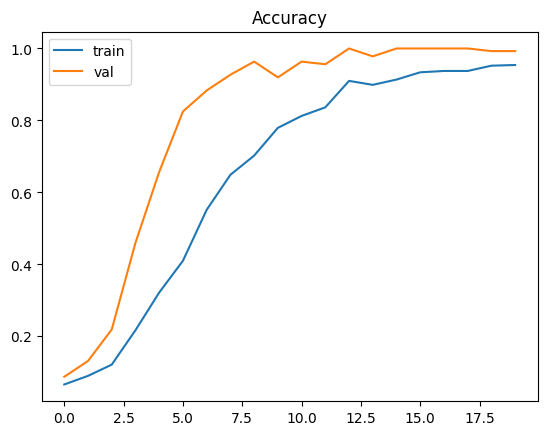

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title("Accuracy")
plt.show()

### Model evaluation using classification report  
Predict class labels on the test set and display precision, recall, and F1-score for each class.


In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        14
           8       0.90      1.00      0.95         9
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        13
          12       1.00      1.00      1.00        12

    accuracy                           0.99       137
   macro avg       0.99      0.99      0.99       137
weighted avg       0.99      0.99      0.99       137



### Inference on random test samples  
Select and predict 5 random test samples to compare the model's predicted labels with the actual labels using the label dictionary.


In [ ]:
import random

print("\n Inference on 5 test samples:\n")

for _ in range(5):
    idx = random.randint(0, len(X_test) - 1)
    sample = np.expand_dims(X_test[idx], axis=0)
    prediction = model.predict(sample, verbose=1)
    pred_label = np.argmax(prediction)

    true_label = y_test[idx]

    print(f" Predicted: {label_dict[pred_label]} |  Actual: {label_dict[true_label]}")


 Inference on 5 test samples:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
 Predicted: my |  Actual: my
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
 Predicted: you |  Actual: you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
 Predicted: lips |  Actual: lips
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
 Predicted: a |  Actual: a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
 Predicted: cat |  Actual: cat


### Visualizing model predictions on test samples  
Predict 10 random test samples, print the predicted vs actual labels, and visualize all frames of each video sample for better interpretability.



Inference on test samples:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Sample #77
Predicted: my | Actual: my



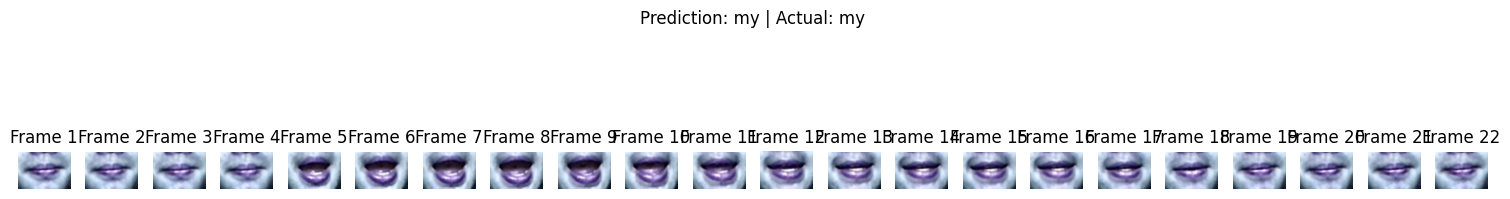

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Sample #132
Predicted: read | Actual: read



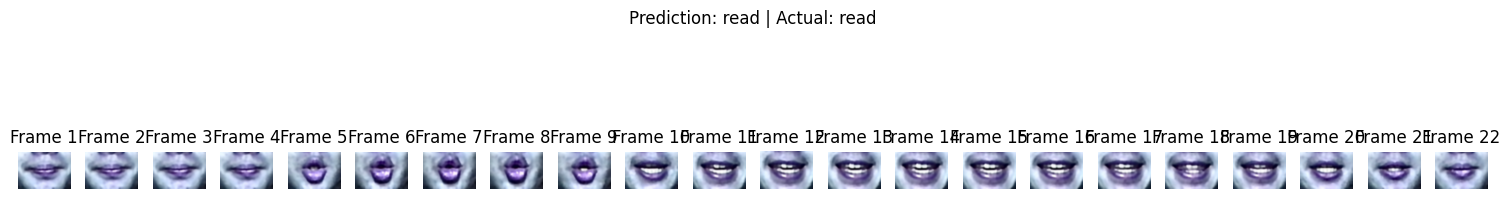

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Sample #120
Predicted: bye | Actual: bye



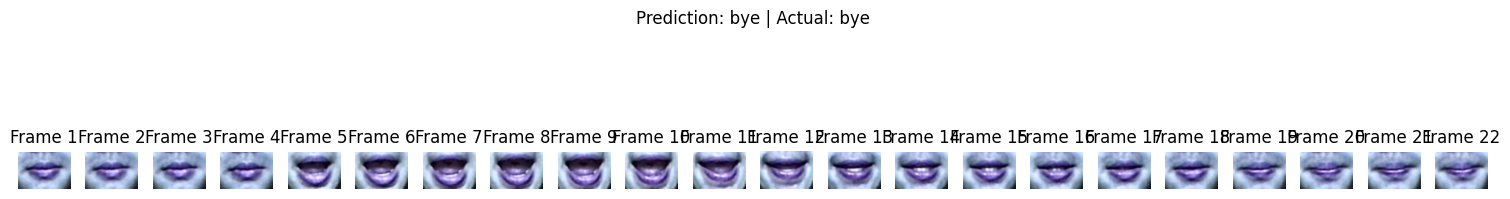

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Sample #53
Predicted: dog | Actual: dog



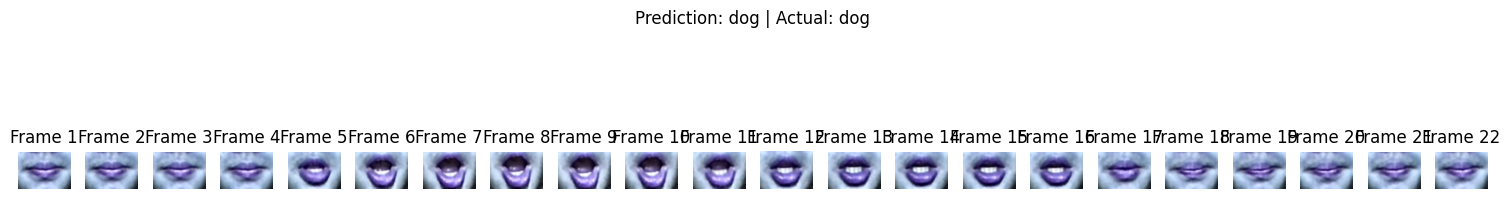

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Sample #78
Predicted: can | Actual: can



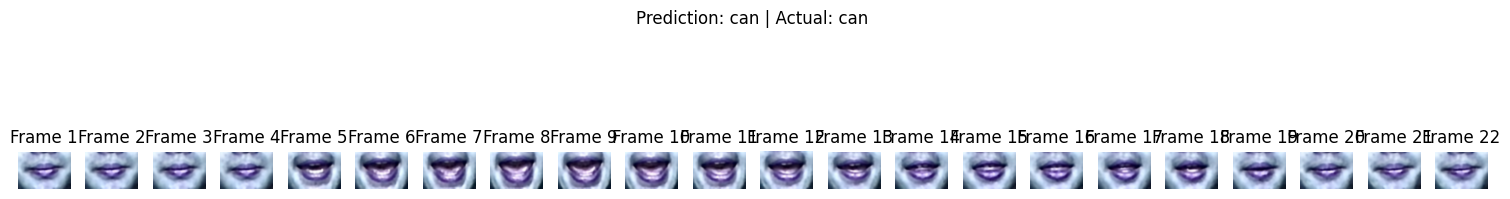

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Sample #124
Predicted: can | Actual: can



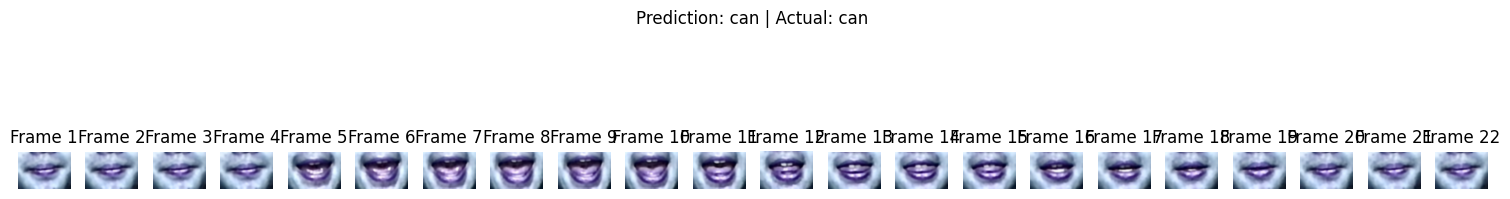

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Sample #79
Predicted: hello | Actual: hello



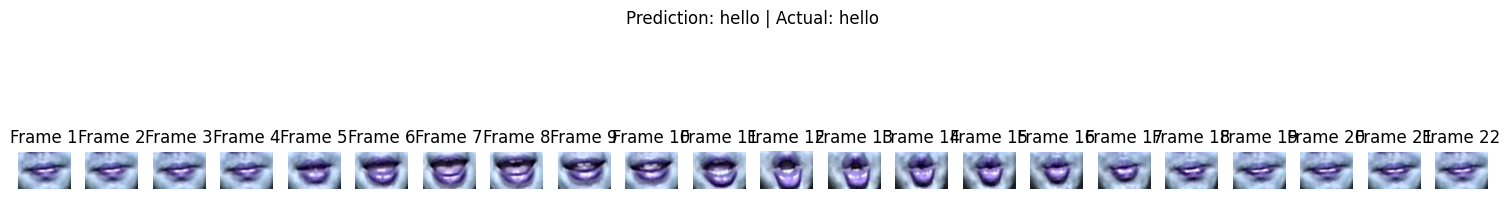

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Sample #120
Predicted: bye | Actual: bye



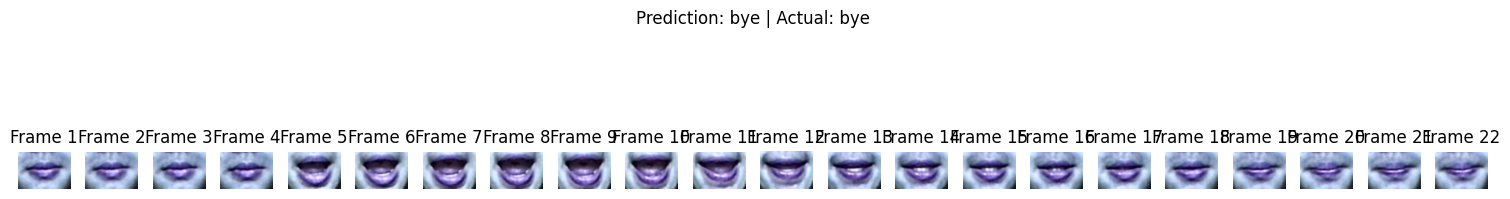

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Sample #27
Predicted: here | Actual: here



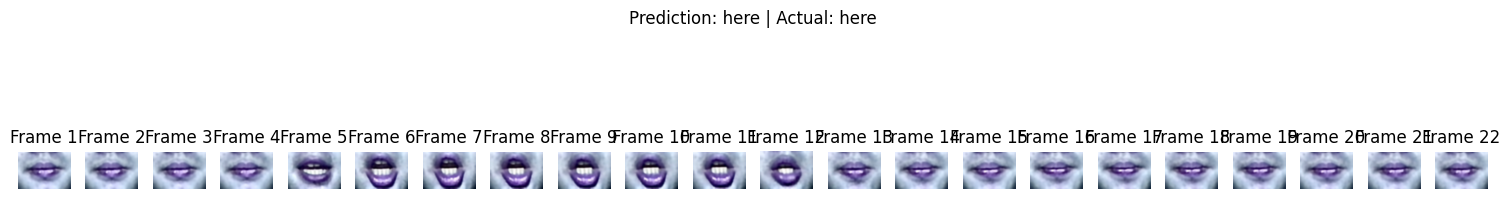

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Sample #39
Predicted: bye | Actual: bye



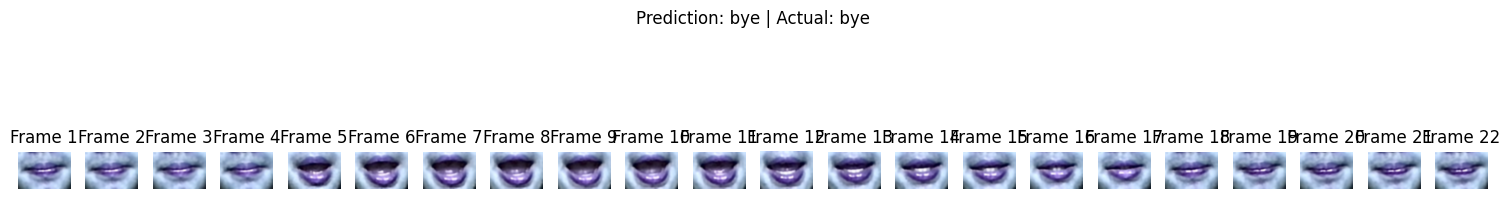

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

print("\nInference on test samples:\n")

for _ in range(10):
    idx = random.randint(0, len(X_test) - 1)
    sample = np.expand_dims(X_test[idx], axis=0)  # shape: (1, T, H, W, C)
    prediction = model.predict(sample, verbose=1)
    pred_label = np.argmax(prediction)
    true_label = y_test[idx]

    print(f"\nSample #{idx}")
    print(f"Predicted: {label_dict[pred_label]} | Actual: {label_dict[true_label]}\n")

    # Visualize the frames
    frames = X_test[idx]  # shape: (T, H, W, C)
    num_frames = frames.shape[0]

    plt.figure(figsize=(15, 3))
    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)
        frame = frames[i]
        if frame.shape[-1] == 1:
            frame = frame.squeeze(-1)
            plt.imshow(frame, cmap='gray')
        else:
            plt.imshow(frame)
        plt.axis('off')
        plt.title(f"Frame {i+1}")
    plt.suptitle(f"Prediction: {label_dict[pred_label]} | Actual: {label_dict[true_label]}")
    plt.tight_layout()
    plt.show()
